In [1]:
# import the packages
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot

import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#download training and test data
!wget -cO - https://datahack-prod.s3.amazonaws.com/train_file/train_s3TEQDk.csv > train_data.csv
!wget -cO - https://datahack-prod.s3.amazonaws.com/test_file/test_mSzZ8RL.csv > test_data.csv

--2021-05-30 13:52:17--  https://datahack-prod.s3.amazonaws.com/train_file/train_s3TEQDk.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.156.47
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.156.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13782835 (13M) [text/csv]
Saving to: ‘STDOUT’

-                   100%[===================>]  13.14M  10.1MB/s    in 1.3s    

2021-05-30 13:52:19 (10.1 MB/s) - written to stdout [13782835/13782835]

--2021-05-30 13:52:19--  https://datahack-prod.s3.amazonaws.com/test_file/test_mSzZ8RL.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.156.47
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.156.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5696419 (5.4M) [text/csv]
Saving to: ‘STDOUT’

-                   100%[===================>]   5.43M

In [3]:
# remove ID and Is_Lead column from train data and separate out y_train
train_data = pd.read_csv('train_data.csv')
train_data.drop(['ID'],axis=1,inplace=True)
Y_train = train_data['Is_Lead']
train_data.drop(['Is_Lead'], axis=1, inplace=True)

# remove ID column from test data
test_data= pd.read_csv('test_data.csv')
z1 = test_data.drop(['ID'], axis=1)
dataframe = pd.concat([train_data, z1], axis=0)
print(train_data.shape, train_data.columns)


(245725, 9) Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],
      dtype='object')


In [4]:
# checking out for imbalance dataset
dataframe['Credit_Product'] = dataframe['Credit_Product'].map({'Yes':1 ,'No':0})
train_data = dataframe.iloc[:train_data.shape[0],:]
print("percentage of imbalance data", Y_train.astype(bool).sum(axis=0)/Y_train.shape[0], Y_train[Y_train == 1].shape)
z1 = dataframe.iloc[train_data.shape[0]:,:]
print(train_data.shape, z1.shape)

percentage of imbalance data 0.23720826126767727 (58288,)
(245725, 9) (105312, 9)


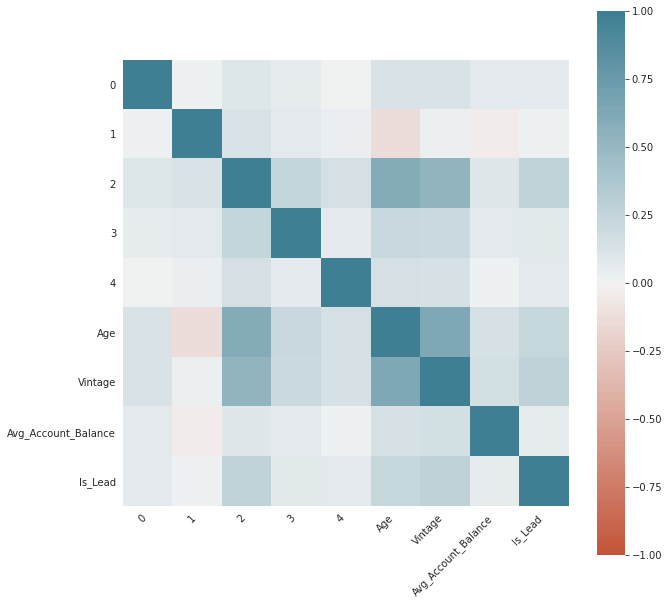

In [7]:
import matplotlib.pyplot as plt
# correlation and heatmap
columnTransformer = ColumnTransformer([('encoder', OrdinalEncoder(), ['Region_Code','Occupation','Channel_Code','Is_Active','Gender'])])
X = pd.concat([pd.DataFrame(columnTransformer.fit_transform(train_data)), train_data.drop(['Region_Code','Occupation','Channel_Code','Is_Active','Gender','Credit_Product'],axis=1)], axis=1)
y=Y_train

data = pd.concat([X,y], axis=1)
corr = data.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [8]:
# data fit transformation using onehot encoding and log transformation
cols = ['Region_Code','Occupation','Channel_Code','Is_Active','Gender']
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(drop='first', sparse=False), cols)])
transformed = pd.concat([pd.DataFrame(columnTransformer.fit_transform(train_data)), train_data.drop(cols,axis=1)], axis=1)
transformed['Avg_Account_Balance'] = np.log(transformed['Avg_Account_Balance'])

# fit imputer on the dataset
imputer = IterativeImputer()
imputer.fit(transformed)
transformed = imputer.transform(transformed)

# Scaling of data
scaler = StandardScaler()
trans_train = scaler.fit_transform(transformed)

# test data transform
test_trans = pd.concat([pd.DataFrame(columnTransformer.transform(z1)), z1.drop(cols,axis=1)], axis=1)
test_trans['Avg_Account_Balance'] = np.log(test_trans['Avg_Account_Balance'])
test_trans = imputer.transform(test_trans)
trans_test = scaler.transform(test_trans)

# handle imbalance dataset using resampling
# sme = SMOTEENN(random_state=42)
# trans_train, Y_train = sme.fit_resample(trans_train, Y_train)
print(trans_test.shape, trans_train.shape, Y_train.shape)

(105312, 46) (245725, 46) (245725,)


In [9]:

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'roc_auc'

# Spot-Check Algorithms
models = []
models.append(('LGBM', lgb.LGBMClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('Rd', RandomForestClassifier()))


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, trans_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LGBM: 0.873795 (0.002537)
XGB: 0.872539 (0.002927)
GBM: 0.872513 (0.002853)
Rd: 0.853365 (0.003292)


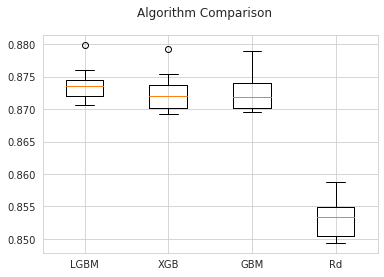

In [10]:
# Compare Algorithms using whisker plot
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [12]:

#Split in 75% train and 25% test set
train_x,test_x,train_y,test_y = train_test_split(trans_train, Y_train, test_size = 0.25, random_state= 1984)


#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x, label=train_y)

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'random_state' : 501, # Updated from 'seed'
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.05,0.1],
    'n_estimators': [200, 500],
    'num_leaves': [6,16],
    'colsample_bytree' : [0.6, 0.9],
    'subsample' : [0.6,0.75],
    # 'reg_alpha' : [1,1.4],
    # 'reg_lambda' : [1,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=4,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(train_x, train_y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 280,
                 verbose_eval= 4
                 )

#Predict on test set
predictions_lgbm_prob = lgbm.predict(test_x)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(test_y,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_y, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  9.7min
[Parallel(n_jobs=2)]: Done 128 out of 128 | elapsed: 13.8min finished


{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 16, 'subsample': 0.6}
0.8559033777267322


KeyError: ignored

In [16]:
print(params)

{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 3, 'num_leaves': 6, 'learning_rate': 0.05, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.75, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'reg_alpha': 1, 'reg_lambda': 1.4, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}


In [13]:

#------------------------Build LightGBM Model on gridsearch values trained on multiple instances-----------------------
train_data=lgb.Dataset(trans_train, label= Y_train)


params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 3, 'num_leaves': 16, 'learning_rate': 0.1,
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.6, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'reg_alpha': 1,
          'reg_lambda': 1.6, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'num_class': 1,
          'metric': 'binary_error', 'is_unbalance':'true', 'n_estimators': 300}


#Train model on selected parameters and number of iterations
model1 = lgb.train(params,
                 train_data,
                 verbose_eval= 4
                 )



/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [14]:
pred = model1.predict(trans_test)
final1=pd.DataFrame()
final1['Is_Lead'] = pred.reshape(-1,)
final=pd.DataFrame()
final['ID'] = test_data['ID']
final=final.join(final1)
print(final.info())

final.to_csv('prediction.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ID       105312 non-null  object 
 1   Is_Lead  105312 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.6+ MB
None
